## Imports

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import utils
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.impute import SimpleImputer
from feature_engine.timeseries.forecasting import LagFeatures
from test_features import _merge_external_data, create_features, covid_dates 

## Helper Functions

In [15]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

def _encode_dates(X, cols=['date']):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    for time_col in cols:
        X[f"{time_col}_year"] = X[time_col].dt.year
        X[f"{time_col}_month"] = X[time_col].dt.month
        X[f"{time_col}_day"] = X[time_col].dt.day
        X[f"{time_col}_weekday"] = X[time_col].dt.weekday
        X[f"{time_col}_hour"] = X[time_col].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=cols)

def get_test_data(path="data/final_test.parquet"):
    data = pd.read_parquet(path)
    # Sort by date first, so that time based cross-validation would produce correct results
    #data = data.sort_values(["date", "counter_name"])
    X_test = data.copy()
    return X_test


## Load Data and Examine Features

In [98]:
df = pd.read_parquet('data/train.parquet')
df = df.sort_values(['date', 'counter_name'])
y = df['log_bike_count']
df.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id', 'latitude', 'longitude', 'log_bike_count'],
      dtype='object')

In [14]:
min(df.date), max(df.date)

(Timestamp('2020-09-01 01:00:00'), Timestamp('2021-09-09 23:00:00'))

In [8]:
test = pd.read_parquet('data/final_test.parquet')
min(test.date), max(test.date)

(Timestamp('2021-09-10 01:00:00'), Timestamp('2021-10-18 21:00:00'))

### Examine differences by counters

In [ ]:
df['counter_name'].value_counts()

/var/folders/r1/zm8ykk152sd7cbxl9gl6qh8h0000gn/T/ipykernel_20973/3958403521.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counters = df.groupby(by='counter_name')['bike_count'].mean()


<Axes: xlabel='counter_name'>

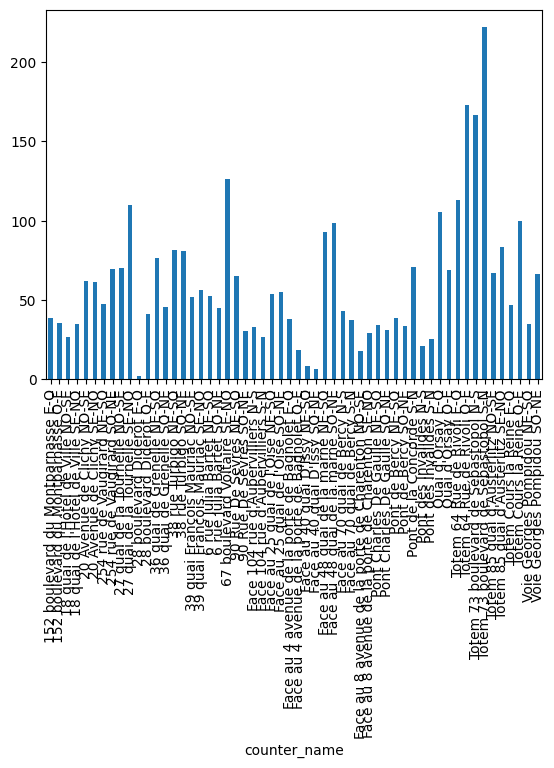

In [107]:
counters = df.groupby(by='counter_name')['bike_count'].mean()

counters.plot(kind='bar')

### Examine differences by dates

In [17]:
date_encoder = FunctionTransformer(_encode_dates, validate=False)
dfs = date_encoder.fit_transform(df)
dfs.head()

,counter_id,counter_name,site_id,site_name,bike_count,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count,date_year,date_month,date_day,date_weekday,date_hour
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,4.0,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,1.609438,2020,9,1,1,1
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,3.0,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,1.386294,2020,9,1,1,1
87516,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,0.0,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,0.000000,2020,9,1,1,1
98518,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,1.0,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,0.693147,2020,9,1,1,1
875137,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,7.0,2020-07-22,"48.88529,2.32666",Y2H20073268,48.885290,2.326660,2.079442,2020,9,1,1,1


In [90]:
# df['date'] = pd.to_datetime(df['date'])

# # Extract the month and define seasons
# df['month'] = df['date'].dt.month
# df['hour'] = df['date'].dt.hour
# df['weekday'] = df['date'].dt.weekday

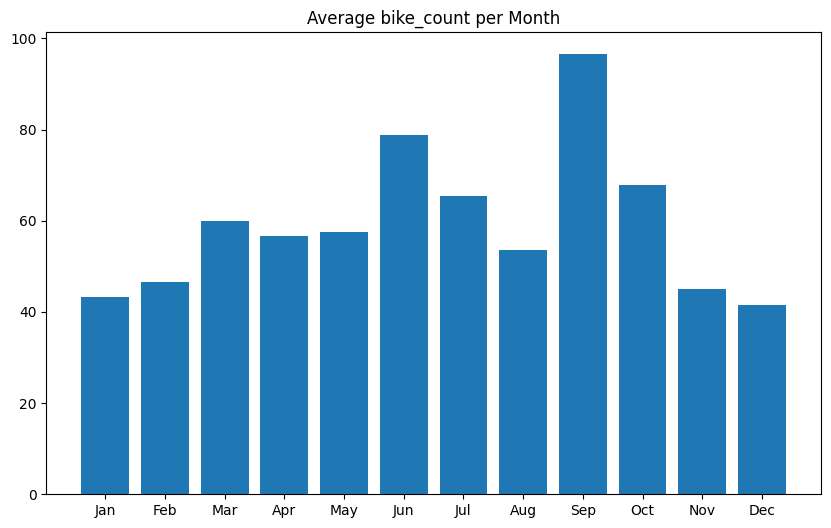

In [19]:
import calendar

monthly = dfs.groupby(by='date_month')['bike_count'].mean()
plt.figure(figsize=(10, 6))
plt.xticks(ticks=monthly.index,
           labels=[calendar.month_abbr[i] for i in monthly.index])

plt.bar(monthly.index, monthly.values)
plt.title("Average bike_count per Month")
plt.show()

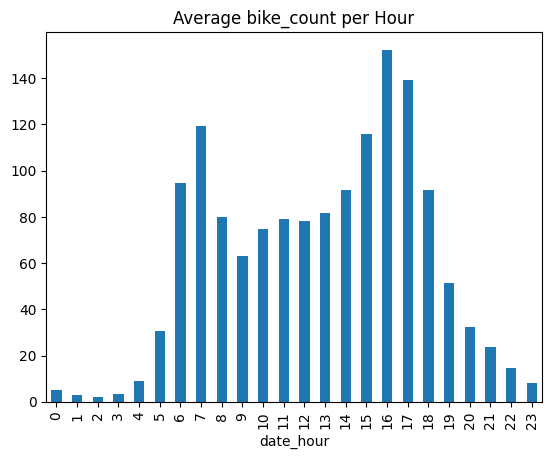

In [20]:
hourly = dfs.groupby(by='date_hour')['bike_count'].mean()
hourly.plot(kind='bar')
plt.title('Average bike_count per Hour')
plt.show()

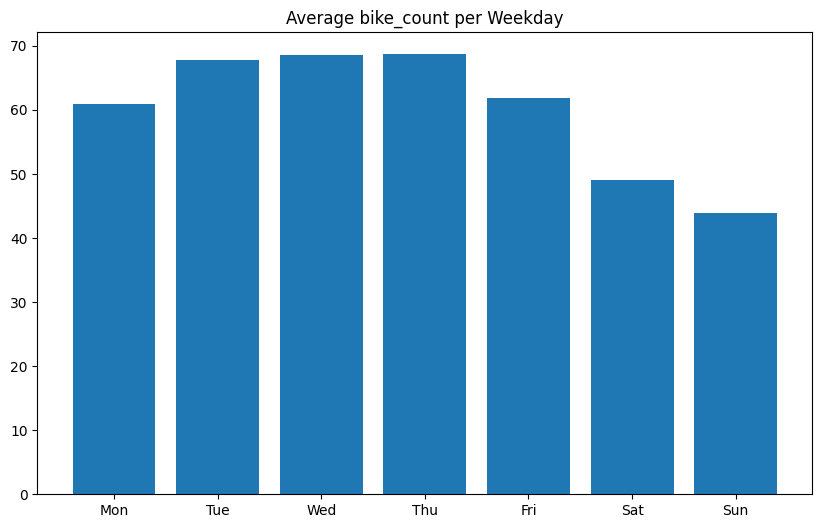

In [94]:
weekdays = df.groupby(by='date_weekday')['bike_count'].mean()

plt.figure(figsize=(10, 6))
plt.bar(weekdays.index, weekdays.values)
plt.xticks(ticks=weekdays.index,
           labels=[calendar.day_abbr[i] for i in weekdays.index])

plt.title("Average bike_count per Weekday")
plt.show()

In [ ]:
c1 = pd.date_range(start='2020-10-05', end='2020-12-14')
c2 = pd.date_range(start='2021-03-20', end='2021-05-03')
covid1 = df[df.date.isin(c1)]

In [ ]:
from scipy.stats import ttest_ind

for i in range(len(df)):
    df['season'] = df['month'].apply(
        lambda x: 'Winter' if x in [12, 1, 2] else 'Summer' if x in [6, 7, 8] else 'Other'
    )

# Filter data for Winter and Summer
winter_data = np.exp(y[df['season'] == 'Winter']) - 1
summer_data = np.exp(y[df['season'] == 'Summer']) - 1

# # Perform an independent t-test
# t_stat, p_value = ttest_ind(winter_data, summer_data, equal_var=False, nan_policy='omit')

# # Display results
# print(f"t-statistic: {t_stat}")
# print(f"p-value: {p_value}")


t-statistic: -69.94586598928954
p-value: 0.0


## Hourly Weather Data

### Load data

In [4]:
X, y = utils.get_train_data()

In [5]:
weather = pd.read_csv(
    "data/H_75_previous-2020-2022.csv.gz",
    parse_dates=["AAAAMMJJHH"],
    date_format="%Y%m%d%H",
    compression="gzip",
    sep=";",
).rename(columns={"AAAAMMJJHH": "date"})

weather = weather[
    (weather["date"] >= X["date"].min())
    & (weather["date"] <= X["date"].max())
]

w = (
    weather.drop(columns=["NUM_POSTE", "NOM_USUEL", "LAT", "LON"])
    .groupby("date")
    .mean()
    .dropna(axis=1, how="all")
    .interpolate(method="linear")
)

In [6]:
w.columns

Index(['ALTI', 'RR1', 'QRR1', 'DRR1', 'QDRR1', 'FF', 'QFF', 'DD', 'QDD', 'FXY',
       'QFXY', 'DXY', 'QDXY', 'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI',
       'HXI', 'QHXI', 'FXI3S', 'QFXI3S', 'QDXI3S', 'HFXI3S', 'QHFXI3S', 'T',
       'QT', 'TD', 'QTD', 'TN', 'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX',
       'QHTX', 'DG', 'QDG', 'T10', 'QT10', 'T20', 'QT20', 'T50', 'QT50',
       'T100', 'QT100', 'TNSOL', 'QTNSOL', 'TN50', 'QTN50', 'TCHAUSSEE',
       'QTCHAUSSEE', 'U', 'QU', 'UN', 'QUN', 'HUN', 'QHUN', 'UX', 'QUX', 'HUX',
       'QHUX', 'DHUMI40', 'QDHUMI40', 'DHUMI80', 'QDHUMI80', 'TSV', 'QTSV',
       'PMER', 'QPMER', 'PSTAT', 'QPSTAT', 'PMERMIN', 'QPMERMIN', 'VV', 'QVV',
       'DVV200', 'QDVV200', 'WW', 'QWW', 'NEIGETOT', 'QNEIGETOT', 'GLO',
       'QGLO', 'GLO2', 'QGLO2', 'INS', 'QINS', 'INS2', 'QINS2'],
      dtype='object')

In [11]:
len(w)

8975

### Checking NaNs

In [9]:
def check_w_nan(col):
    nan_rows = w[col].isna()
    if len(w[nan_rows]) > 0:
        print(col)
        print(w[col].value_counts())
        print(w[nan_rows].index)
    # else:
    #     print("All Good")

def check_x_nan(cols):
    nan_rows = X[cols].isna()
    nan_indices = X[nan_rows.any(axis=1)].index
    rows_with_nan = X.loc[nan_indices]
    rows_with_nan

In [10]:
for col in w.columns:
    check_w_nan(col)

QDXI3S
QDXI3S
1.0    3054
Name: count, dtype: int64
DatetimeIndex(['2020-09-01 01:00:00', '2020-09-01 02:00:00',
               '2020-09-01 03:00:00', '2020-09-01 04:00:00',
               '2020-09-01 05:00:00', '2020-09-01 06:00:00',
               '2020-09-01 07:00:00', '2020-09-01 08:00:00',
               '2020-09-01 09:00:00', '2020-09-01 10:00:00',
               ...
               '2021-05-05 08:00:00', '2021-05-05 09:00:00',
               '2021-05-05 10:00:00', '2021-05-05 11:00:00',
               '2021-05-05 12:00:00', '2021-05-05 13:00:00',
               '2021-05-05 14:00:00', '2021-05-05 15:00:00',
               '2021-05-05 16:00:00', '2021-05-05 17:00:00'],
              dtype='datetime64[ns]', name='date', length=5921, freq=None)


In [ ]:
w.loc[(w.index < '2021-02-01') & (w.index >= '2021-01-31')][['T', 'NEIGETOT', 'RR1']]

In [ ]:
snowing = w[w['is_snow'] == 1]
min(snowing.index), max(snowing.index)

In [ ]:
X, y = utils.get_train_data()
y = y.reshape(-1, 1)

### Merge

In [7]:
X = X.merge(w, on='date', how='left')

In [8]:
X_cleaned = X.copy()

q_indicators = [col for col in X.columns if col.startswith('Q')]
# feature_pairs = [(col[1:], col) for col in q_indicators]

#     # Drop rows where 'Q' features indicate untrustworthiness
# for feature, q_feature in feature_pairs:
#     X_cleaned = X_cleaned[X_cleaned[q_feature] != 2]

X_cleaned = X_cleaned.drop(columns=q_indicators)
X_cleaned

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,...,PSTAT,PMERMIN,VV,DVV200,WW,NEIGETOT,GLO,GLO2,INS,INS2
0,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,1010.7,1020.1,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,1010.7,1020.1,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,...,1010.7,1020.1,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,...,1010.7,1020.1,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2020-09-01 01:00:00,2020-07-22,"48.88529,2.32666",Y2H20073268,48.885290,2.326660,...,1010.7,1020.1,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496822,100057329-103057329,Totem 85 quai d'Austerlitz SE-NO,100057329,Totem 85 quai d'Austerlitz,2021-09-09 23:00:00,2020-02-18,"48.84201,2.36729",YTH19111508,48.842010,2.367290,...,1003.1,1012.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496823,100057380-104057380,Totem Cours la Reine E-O,100057380,Totem Cours la Reine,2021-09-09 23:00:00,2020-02-11,"48.86462,2.31444",YTH19111509,48.864620,2.314440,...,1003.1,1012.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496824,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,2021-09-09 23:00:00,2020-02-11,"48.86462,2.31444",YTH19111509,48.864620,2.314440,...,1003.1,1012.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496825,100042374-110042374,Voie Georges Pompidou NE-SO,100042374,Voie Georges Pompidou,2021-09-09 23:00:00,2017-12-15,"48.8484,2.27586",Y2H21025335,48.848400,2.275860,...,1003.1,1012.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# def create_features(X):

#     X["is_rain"] = (X["RR1"] > 0).astype(int)
#     X['is_snow'] = (X['NEIGETOT'] > 0).astype(int)
#     X['wind_chill'] = 13.12 + 0.6215 * X['T'] - 11.37 * (X['FF']*3.6)**0.16 + 0.3965 * X['T'] * (X['FF']*3.6)**0.16
#     X['is_rush_hour'] = (
#         (X['date'].dt.hour >= 8) & (X['date'].dt.hour < 10) | 
#         (X['date'].dt.hour >= 17) & (X['date'].dt.hour < 20)
#     ).astype(int)

#     return X


In [9]:
X_big = create_features(X_cleaned)
X_cleaned.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'date',
       'counter_installation_date', 'coordinates', 'counter_technical_id',
       'latitude', 'longitude', 'ALTI', 'RR1', 'DRR1', 'FF', 'DD', 'FXY',
       'DXY', 'HXY', 'FXI', 'DXI', 'HXI', 'FXI3S', 'HFXI3S', 'T', 'TD', 'TN',
       'HTN', 'TX', 'HTX', 'DG', 'T10', 'T20', 'T50', 'T100', 'TNSOL', 'TN50',
       'TCHAUSSEE', 'U', 'UN', 'HUN', 'UX', 'HUX', 'DHUMI40', 'DHUMI80', 'TSV',
       'PMER', 'PSTAT', 'PMERMIN', 'VV', 'DVV200', 'WW', 'NEIGETOT', 'GLO',
       'GLO2', 'INS', 'INS2', 'is_rain', 'is_snow', 'wind_chill',
       'is_rush_hour'],
      dtype='object')

## HGB Model

In [56]:
X, y = utils.get_train_data()
y = y.reshape(-1, 1)
# print(y.shape)
# print(X.info())
#y = np.exp(y)
X = _merge_external_data(X)
X = covid_dates(X)
X = create_features(X)

X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)
X_train, y_train = X, y #retraining on full dataset
# print(f'Data: {X.columns}')
# print(X.info())

date_encoder = FunctionTransformer(_encode_dates)
#make sure to pass any date columns here as well
date_cols = _encode_dates(X[["date"]]).columns.tolist() 
categorical_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
categorical_cols = ["counter_name", "site_name"]
binary_cols = ['in_date_range', 'is_rain', 'is_snow', 'is_rush_hour']
location_cols = ['latitude', 'longitude']
numerical_cols = ['T', 
                  'DRR1', 'FF', 'FXY', 'FXI', 'FXI3S', 
                  'RR1', 'TD', 'TN', 'TX', 'DG', 'U', 'UX', 'DHUMI40',
                  'DHUMI80', 'INS', 'VV', 'DVV200', 'NEIGETOT', 'wind_chill'
                  ]
lag_transformer = LagFeatures(variables=['T', 'NEIGETOT'], periods=[24, 48], missing_values='ignore')

#these are created later, can find these with get_features_out
lagged_cols = ['T_lag_24', 'NEIGETOT_lag_24',
               #'pmer_lag_24', 'tend_lag_24', 'cod_tend_lag_24', 'dd_lag_24', 'ff_lag_24', 'td_lag_24', 'u_lag_24', 'vv_lag_24', 
               'T_lag_48', 'NEIGETOT_lag_48'
               #'pmer_lag_48', 'tend_lag_48', 'cod_tend_lag_48', 'dd_lag_48', 'ff_lag_48', 'td_lag_48', 'u_lag_48', 'vv_lag_48'
               ]

In [67]:
preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore", sparse_output=False), date_cols),
        #("install", OneHotEncoder(handle_unknown="ignore"), install_cols),
        ("cat", categorical_encoder, categorical_cols),
        ('location', 'passthrough', location_cols),
        # ('numerical', 'passthrough', numerical_cols),
        # ('lagged', 'passthrough', lagged_cols),
        ('binary', 'passthrough', binary_cols)
    ],
    #remainder='passthrough'
)

regressor = HistGradientBoostingRegressor(max_leaf_nodes=50, verbose=1, max_iter=700)


# print(f'Building with {regressor}')


pipe = Pipeline([
    # ('lag_features', lag_transformer),
    # ('date_encoder', date_encoder),
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])


## Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


# Define the hyperparameter grid
param_grid = {
    'regressor__learning_rate': [0.1, 0.2],
    'regressor__max_iter': [2000, 5000],
    'regressor__max_leaf_nodes': [31, 50],
    # 'regressor__min_samples_leaf': [10, 20, 30],
    'regressor__l2_regularization': [0.0, 0.05, 0.1]
}

# Set up RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=20,  # Number of random samples
    scoring='neg_mean_squared_error',
    cv=5,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1  # Use all processors for parallel computation
)

# Fit the search
search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)

In [14]:
X_test = get_test_data()
X_test = _merge_external_data(X_test)
X_test = covid_dates(X_test)
X_test = create_features(X_test)
y_pred = pipe.predict(X_test)

## Feature Importance

In [59]:
X.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'date',
       'counter_installation_date', 'coordinates', 'counter_technical_id',
       'latitude', 'longitude', 'RR1', 'DRR1', 'FF', 'FXY', 'FXI', 'FXI3S',
       'T', 'TD', 'TN', 'TX', 'DG', 'U', 'UX', 'DHUMI40', 'DHUMI80', 'INS',
       'VV', 'DVV200', 'NEIGETOT', 'in_date_range', 'is_rain', 'is_snow',
       'wind_chill', 'is_rush_hour'],
      dtype='object')

### First try

In [27]:


# Calculate permutation importance after fitting the pipeline
result = permutation_importance(
    pipe, X_train, y_train, n_repeats=5, random_state=0, scoring='neg_mean_squared_error', n_jobs=-1
)

# Combine results into a DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))

         Feature  Importance
4           date    2.377246
25           INS    0.693391
3      site_name    0.399240
1   counter_name    0.361713
33  is_rush_hour    0.335159
8       latitude    0.093090
16             T    0.084828
9      longitude    0.064280
32    wind_chill    0.029564
17            TD    0.023913


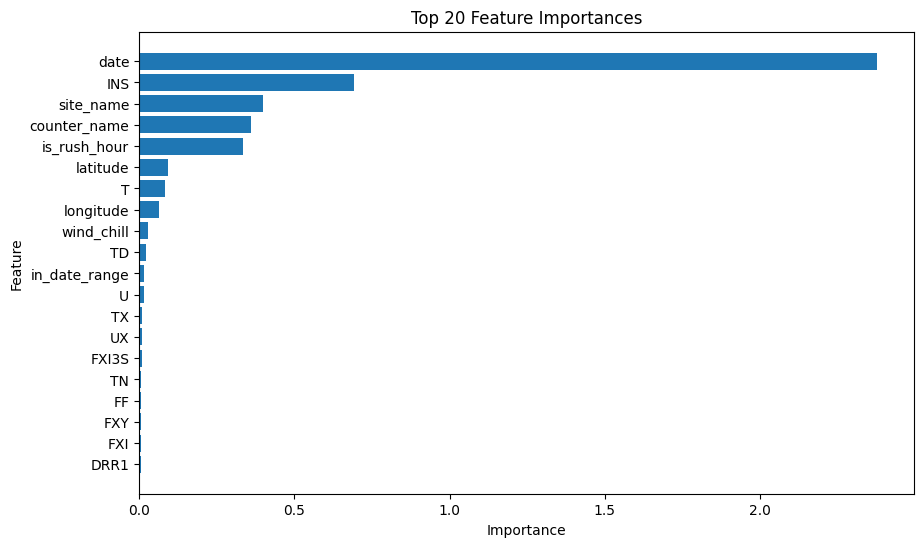

In [28]:
top_features = importance_df.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.show()

### Replicate result
(Trying to rename the features but unfortunately lost the result after a 5-hour run. )

In [50]:
c_graph = ['date', 'hourly_sunshine', 'site_name', 'counter_name', 'is_rush_hour',
           'latitude', 'temperature', 'longitude', 'wind_chill', 'dew_point',
           'in_date_range', 'relative_humidity', 'max_temp', 'max_rel_humid', 'max_wind_force',
           'min_temp', 'wind_force', 'max_avg_wind_force', 'max_wind_force', 'rain_duration']


values = [2.37, 0.75, 0.45, 0.4, 0.38,
          0.1, 0.09, 0.07, 0.03, 0.023,
          0.02, 0.019, 0.01, 0.007, 0.007,
          0.007, 0.007, 0.007, 0.007, 0.007]



graph_df = pd.DataFrame({'Feature': c_graph, 'Importance': values})

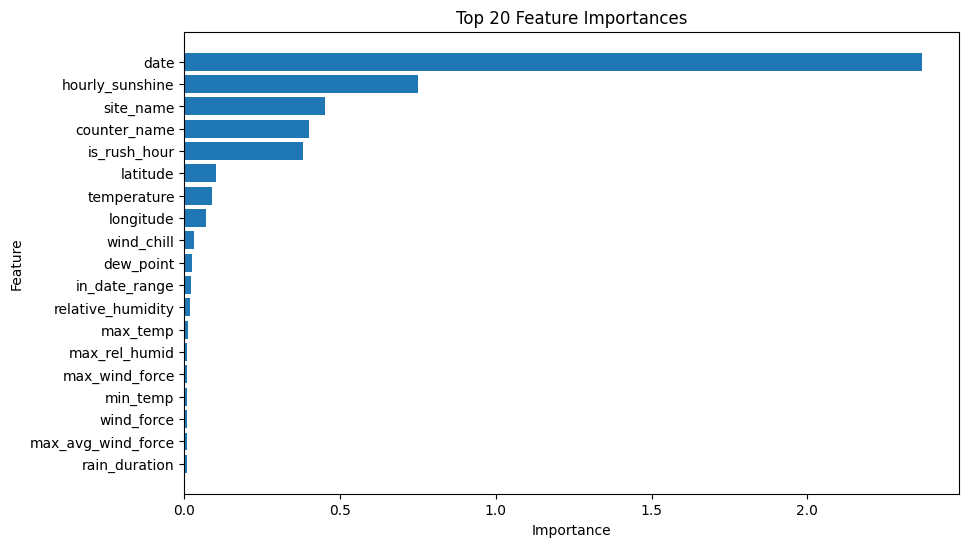

In [51]:
plt.figure(figsize=(10, 6))
plt.barh(graph_df['Feature'], graph_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.show()

### Second try with splitted dates

In [70]:
X_train_date_split = date_encoder.fit_transform(X_train)

valid_col = ['wind_chill', 'is_rush_hour', 'date_year', 'date_month', 'date_day',
             'date_weekday', 'date_hour', 'INS', 'site_name', 'counter_name',
             'latitude', 'T', 'longitude', 'TD', 'in_date_range', 'is_rain',
             'is_snow']


X_train_date_split = X_train_date_split[valid_col]
X_train_date_split.columns

Index(['wind_chill', 'is_rush_hour', 'date_year', 'date_month', 'date_day',
       'date_weekday', 'date_hour', 'INS', 'site_name', 'counter_name',
       'latitude', 'T', 'longitude', 'TD', 'in_date_range', 'is_rain',
       'is_snow'],
      dtype='object')

In [71]:
from sklearn.inspection import permutation_importance

numerical_cols = ['INS', 'wind_chill', 'T', 'TD']
pipe.fit(X_train_date_split, y_train)


r2 = permutation_importance(
    pipe, X_train_date_split, y_train, n_repeats=5, random_state=0, scoring='neg_mean_squared_error', n_jobs=-1
)

# Combine results into a DataFrame
importance_df2 = pd.DataFrame({
    'Feature': X_train_date_split.columns,
    'Importance': r2.importances_mean
}).sort_values(by='Importance', ascending=False)

print(importance_df2.head(10))

/Users/chwang/Library/CloudStorage/OneDrive-HECParis/Course Materials/2024-25 X/Python/pyds_howard/pyds/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.601 GB of training data: 0.944 s
Binning 0.067 GB of validation data: 0.043 s
Fitting gradient boosted rounds:
[1/700] 1 tree, 50 leaves, max depth = 26, train loss: 1.18714, val loss: 1.18194, in 0.160s
[2/700] 1 tree, 50 leaves, max depth = 26, train loss: 1.03143, val loss: 1.02742, in 0.142s
[3/700] 1 tree, 50 leaves, max depth = 26, train loss: 0.90530, val loss: 0.90239, in 0.136s
[4/700] 1 tree, 50 leaves, max depth = 26, train loss: 0.80148, val loss: 0.79899, in 0.141s
[5/700] 1 tree, 50 leaves, max depth = 29, train loss: 0.71754, val loss: 0.71555, in 0.153s
[6/700] 1 tree, 50 leaves, max depth = 27, train loss: 0.64772, val loss: 0.64619, in 0.152s
[7/700] 1 tree, 50 leaves, max depth = 24, train loss: 0.59029, val loss: 0.58915, in 0.136s
[8/700] 1 tree, 50 leaves, max depth = 21, train loss: 0.54097, val loss: 0.54032, in 0.141s
[9/700] 1 tree, 50 leaves, max depth = 21, train loss: 0.50110, val loss: 0.50086, in 0.142s
[10/700] 1 tree, 50 leaves, max depth = 23

In [72]:
print(importance_df2.head(10))

         Feature  Importance
6      date_hour    3.475296
3     date_month    0.603328
8      site_name    0.407148
9   counter_name    0.365257
5   date_weekday    0.226346
4       date_day    0.111243
10      latitude    0.106991
12     longitude    0.049979
1   is_rush_hour    0.019956
15       is_rain    0.019010


In [84]:
mapping = {'TD': 'dew_point',
           'T': 'temperature',
           'INS': 'hourly_sunshine'}


importance_df2['Feature'] = importance_df2['Feature'].replace(mapping)

In [86]:
importance_df2.to_csv('fi_date_split.csv')

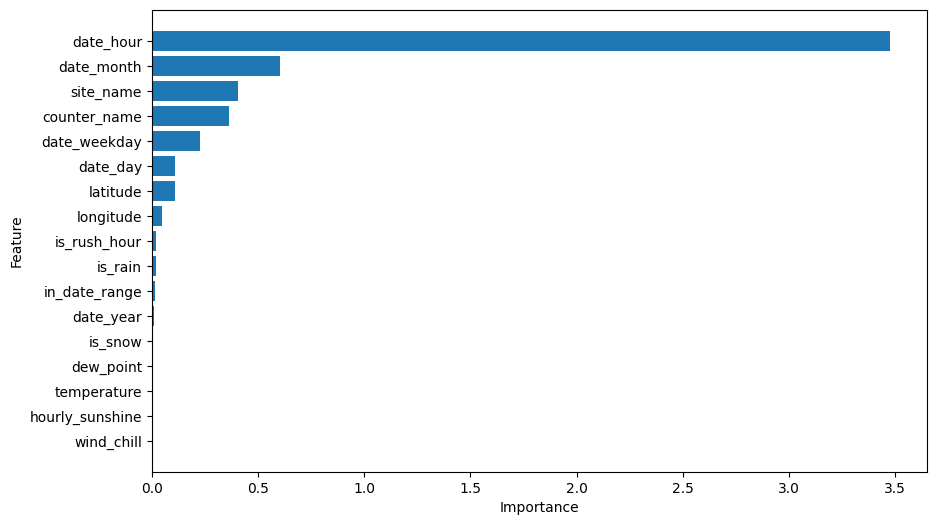

In [85]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df2['Feature'], importance_df2['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()